# метод EDS: Executable Data Structures
## вычисления на объектных графах в Python
#### краткое описание метода использованного в *meteo.kit*

(c) Dmitry Ponyatov <<dponyatov@gmail.com>>

## Объектный граф

[Объектный граф](https://en.wikipedia.org/wiki/Object_graph) -- структура данных, состоящая из объектов, связанных между собой направленными связями (ссылками). Каждый узел графа может иметь 
* `val` одиночное значение: имя объекта, значение числа/строки
* `nest[]` набор *упорядоченных* ссылок на другие узлы, и 
* `slot{}` набор *атрибутов* адресуемых по их именам
* `sid` уникальный идентификатор объекта, уникальный для хранилища или глобально (**s**torage id)

Направленный объектный граф формируется в памяти через ссылки между объектами. При сериализации в хранинилищах данных (Redis, DBMS,..) или передаче в распределенных системах возникает необходимость использовать уникальные идентификаторы для каждого объекта, так как необходимо универсальное представление ссылок, переносимое между любыми форматами.

### Универсальная структура представления знаний

Структуры данных, составленные из групп объектов, *отнаследованных* от базового класса `Object`, являются формой *универсального* **представления знаний** ([KR&R](https://en.wikipedia.org/wiki/Knowledge_representation_and_reasoning)). В виде графа могут быть не только данные, но и программы для их обработки, поэтому такая форма *исполняемых данных* позволяет использовать мощную технику *метапрограммирования*, когда программы могут создавать и изменять другие программы.

* [Атрибутные транслирующие грамматики](https://neerc.ifmo.ru/wiki/index.php?title=%D0%90%D1%82%D1%80%D0%B8%D0%B1%D1%83%D1%82%D0%BD%D1%8B%D0%B5_%D1%82%D1%80%D0%B0%D0%BD%D1%81%D0%BB%D0%B8%D1%80%D1%83%D1%8E%D1%89%D0%B8%D0%B5_%D0%B3%D1%80%D0%B0%D0%BC%D0%BC%D0%B0%D1%82%D0%B8%D0%BA%D0%B8)
* Метапрограммирование
  * https://habr.com/ru/post/137446/

Данные не только могут хранить информацию, и обрабатываться внешними программами. Если написать **интерпретатор данных**, и включить в состав хранимых типов классы для описания алгоритмов, процедур и потоков обработки, возможно реализовать мощные вычислительные системы на уровне базы данных (знаний).

## Базовый класс узлов объектного графа

In [1]:
# базовый класс узлов объектного графа
class Object:

    def __init__(self, V, sid=None):
        # № метка типа/класса
        self.type = self.__class__.__name__.lower()
        # № скалярное значение узла (имя, строка, число)
        self.val = V
        # № атрибуты = ассоциативный массив
        self.slot = {}
        # упорядоченный набор ссылок = вектор = стек
        self.nest = []
        # уникальный идентификатор объекта (глобальный или в пределах хранилища)
        if not sid:
            self.sid = id(self)
        else:
            self.sid = sid

### Визуализация графа

#### Текстовый дамп

Для работы с графом или отдельными объектами необходимы средства просмотра его содержимого в человеко-читаемом виде. В простейшем случае это может быть текстовое представление:

In [2]:
print(Object("Hello"))

In [3]:
class Object(Object):  # наследование от самого себя - способ расширения класса в Jupyter

    # служебный метод вызывается из `print()`
    def __repr__(self):
        return self.dump()

    # вывод дампа в виде текстового дерева
    def dump(self, depth=0, prefix=''):
        # заголовок
        tree = self.pad(depth) + self.head(prefix)
        # останов бесконечной рекурсии на циклических ссылках
        if not depth:
            Object._dumped = []
        if self in Object._dumped:
            return tree + ' _/'
        else:
            Object._dumped.append(self)
        # slot{}ы
        for i in self.slot:
            tree += self.slot[i].dump(depth + 1, prefix='%s = ' % i)
        # nest[]ы
        idx = 0
        for j in self.nest:
            tree += j.dump(depth + 1, prefix='%s = ' % idx)
            idx += 1
        # дамп подграфа
        return tree

    # короткий дамп: только <T:V> заголовок
    def head(self, prefix=''):
        return '%s<%s:%s> @%s' % (prefix, self.type, self._val(), self.sid)

    # отбивка пробелами в зависимости от уровня вложенности
    def pad(self, depth):
        return '\n' + '\t' * depth
    # метод форматирует поле .val специально для дампа

    def _val(self):
        return '%s' % self.val

In [4]:
print( Object("Hello") )


<object:Hello> @140570597918480


#### Графическое представление / graphviz /

In [5]:
from graphviz import Digraph

* http://diginal.ru/python/narisovat-graf-s-graphviz-v-jupyter-notebook/

In [6]:
class Object(Object):

    # визуализация графа через библиотеку graphviz
    def plot(self, plot=None, parent=None, label='', color='black'):
        # инициализация или ветвь рекурсии
        if not plot:
            plot = Digraph(comment=self.head())
            plot.graph_attr.update(size="9,9")
            Object.plotted = []
        # остановка рекурсии на циклических графах
        if self in Object.plotted:
            return plot
        else:
            Object.plotted.append(self)
        # вывод узла графа
        plot.node('%s' % self.sid, '%s:%s' % (self.type, self._val()))
        # вывод ребра графа с меткой
        if parent:
            plot.edge('%s' % parent.sid, '%s' % self.sid, label=label, color=color)
        # рекурсия по slot{}
        for i in self.slot:
            plot = self.slot[i].plot(plot, parent=self, label='%s' % i, color='blue')
        # рекурсия по nest[]
        idx = 0
        for j in self.nest:
            plot = j.plot(plot, parent=self, label='/%s' % idx, color='red')
            idx += 1
        # возврат подграфа из рекурсии
        return plot

### Операторы для построения структуры графа

In [7]:
class Object(Object):

    # A[key] получить подграф из слота по имени
    def __getitem__(self, key):
        return self.slot[key]

    # A[key] = B присвоить подграф слотупо имени
    def __setitem__(self, key, that):
        self.slot[key] = that
        return self

    # A << B -> A[B.type] = B присвоить слот по имени типа B
    def __lshift__(self, that):
        return self.__setitem__(that.type, that)

    # A >> B -> A[B.val] = B присвоить слот по значению B
    def __rshift__(self, that):
        return self.__setitem__(that.val, that)

    # A // B -> A.push(B) втолкнуть B как в стек
    def __floordiv__(self, that):
        self.nest.append(that)
        return self

In [8]:
hello = Object('Hello') // Object('World') ; hello


<object:Hello> @140570597619528
	0 = <object:World> @140570597619024

In [9]:
hello['some'] = Object('slot') ; hello


<object:Hello> @140570597619528
	some = <object:slot> @140570597620368
	0 = <object:World> @140570597619024

In [10]:
hello << Object('left')
hello >> Object('right')
hello


<object:Hello> @140570597619528
	some = <object:slot> @140570597620368
	object = <object:left> @140570597155728
	right = <object:right> @140570597155672
	0 = <object:World> @140570597619024

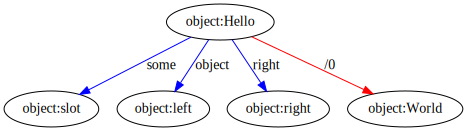

In [11]:
hello.plot()

### Стековые операции

При реализации языков программирования очень широко используется такой подход как [стековая виртуальная машина](https://tech.badoo.com/ru/article/579/interpretatory-bajt-kodov-svoimi-rukami/). Несмотря на то, что почти все современные процессоры являются регистровыми машинами, при реализации интерпреторов наоборот в основном используется стековая архитектура. Как пример, JVM и .NET являются стековыми машинами.

In [12]:
class Object(Object):
    # ( 1 2 3 -- 1 2 4 ) -> 3
    def top(self): return self.nest[-1]
    # ( 1 2 3 -- 1 2 3 ) -> 2
    def tip(self): return self.nest[-2]
    # ( 1 2 3 -- 1 2 ) -> 3
    def pop(self): return self.nest.pop(-1)
    # ( 1 2 3 -- 1 3 ) -> 2
    def pip(self): return self.nest.pop(-2)
    # ( 1 2 3 -- )
    def dropall(self): self.nest = [] ; return self
    # ( 1 2 3 -- 1 2 3 3 )
    def dup(self): return self // self.top()
    # ( 1 2 3 -- 1 2 )
    def drop(self): self.pop() ; return self
    # ( 1 2 3 -- 1 3 2 )
    def swap(self): return self // self.pip()
    # ( 1 2 3 -- 1 2 3 2 )
    def over(self): return self // self.nest[-2]
    # ( 1 2 3 -- 1 3 )
    def press(self): self.pip() ; return self

Выше приведен код, для описания которого в комментариях применялась *стековая нотация*:
* стек растет слева направо, вершина стека самый правый элемент
* запись `--` разделяет состояния стека до и после операции
* скобки используются т.к. в языке Форт они выделяют inline-комментарии в коде
* `->` показывает что возвращается из Python-метода

In [13]:
def stack123(): return Object('stack') // Object(1) // Object(2) // Object(3)

Стековые операции изменяют состояние объекта, а не возвращают новый измененный объект, как это происходит в функциональных языках. Для примеров пришлось завести служебную функцию `stack123()`.

In [14]:
stack = stack123() ; stack


<object:stack> @140570597606120
	0 = <object:1> @140570597606232
	1 = <object:2> @140570597606344
	2 = <object:3> @140570597606456

Поле объектов `nest[]` работает и как стек, на дампе вершина стека находится внизу, с максимальным целочисленным индексом.

In [15]:
print('top',stack.top()) ; print('tip',stack.tip())

top 
<object:3> @140570597606456
tip 
<object:2> @140570597606344


In [16]:
print('pop',stack.pop(),stack)

pop 
<object:3> @140570597606456 
<object:stack> @140570597606120
	0 = <object:1> @140570597606232
	1 = <object:2> @140570597606344


In [17]:
print('pip',stack.pip(),stack)

pip 
<object:1> @140570597606232 
<object:stack> @140570597606120
	0 = <object:2> @140570597606344


## Примитивы

In [18]:
class Primitive(Object): pass
class Symbol(Primitive): pass
class String(Primitive): pass

In [19]:
class Number(Primitive):
    def __init__(self,V): Primitive.__init__(self,float(V))

In [20]:
class Integer(Number):
    def __init__(self,V): Primitive.__init__(self,int(V,0x0A))

In [21]:
class Hex(Integer):
    def __init__(self,V): Primitive.__init__(self,int(V[2:],0x10))
    def _val(self): return hex(self.val) # '0x{0:x}'.format(self.val)

In [22]:
class Bin(Integer):
    def __init__(self,V): Primitive.__init__(self,int(V[2:],0x02))
    def _val(self): return bin(self.val) # '0b{0:b}'.format(self.val)

## Контейнеры

In [23]:
class Container(Object): pass
class Vector(Container): pass
class Array(Container): pass
class Dict(Container): pass
class Stack(Container): pass
class Queue(Container): pass

## Реализация примитивного ЯП
### на базе графовой машины

Вырожденным случаем языка программирования является [язык Форт](http://www.nncron.ru/book/sf/) /[.pdf](http://www.nncron.ru/download/sf.pdf)/, который имеет самый минимально возможный синтаксис и реализацию интерпретатора:
* **любая непробельная группа символов** является командой, или (числовой) константой
* все команды получают параметры и возвращают результат на **стеке**
* привязка значений к именам (команды) выполняется через **словарь**

In [24]:
# использяемые данные
class Active(Object): pass

In [25]:
# виртуальная (форт-)машина
class VM(Active): pass
vm = VM('FORTH') ; print(vm)


<vm:FORTH> @140570606902408


#### Регистрируем функции как команды форт-машины

Отдельный класс-обертка для функций вида `def cmd(context) -> context` , которые принимают в качестве параметра **контекст вычисления**, и возвращают измененный контекст. Для микроФорта единственный контекст -- это общий глобальный объект `vm` который содержит:
* **стек** данных
* ассоциативный список, хранящий привязки имен переменных к из значениям (**environment**, для Форта то же самое что и **словарь**)

Также в контекст могут входить:
* память виртуальной машины: классический Форт адресует память напрямую целочисленными адресами, наш вариант будет работать только через словарь, и использовать символы в качестве адреса)
* любые другие ресурсы, которые должны быть освобождены при завершении текущего вычисления (открытые файлы, сетевые соединения, окна GUI,..)

In [26]:
# команда ВМ (обертка для функций написанных на Python)
class Command(Active):
    def __init__(self, F):
        Active.__init__(self, F.__name__)
        self.fn = F  # функция хранится как дополнительное поле объекта
    def eval(self, env):
        return self.fn(env)

In [27]:
def BYE(ctx): exit(0)
vm >> Command(BYE)


<vm:FORTH> @140570606902408
	BYE = <command:BYE> @140570597302624

#### команды стековых операций

Команды вызывают соответствующие методы объекта `Object`, описанные выше. Для примера пара команд определена через `lambda:`. Команды заданные в виде именованных функций, дают более читаемый дамп

In [28]:
# ( n -- n n )
vm['DUP'] = Command(lambda ctx:ctx.dup())
# ( n1 n2 -- n1 )
vm['DROP'] = Command(lambda ctx:ctx.drop())
# ( n1 n2 -- n2 n1 )
def SWAP(ctx): return ctx.swap()
vm >> Command(SWAP)
# ( n1 n2 -- n1 n2 n1 )
def OVER(ctx): return ctx.over()
vm >> Command(OVER)
# ( n1 n2 -- n2 )
def PRESS(ctx): return ctx.press()
vm >> Command(PRESS)


<vm:FORTH> @140570606902408
	BYE = <command:BYE> @140570597302624
	DUP = <command:<lambda>> @140570597320744
	DROP = <command:<lambda>> @140570597320688
	SWAP = <command:SWAP> @140570597320968
	OVER = <command:OVER> @140570597321136
	PRESS = <command:PRESS> @140570597321248

In [29]:
vm // Object(1) // Object(2) // Object(3)


<vm:FORTH> @140570606902408
	BYE = <command:BYE> @140570597302624
	DUP = <command:<lambda>> @140570597320744
	DROP = <command:<lambda>> @140570597320688
	SWAP = <command:SWAP> @140570597320968
	OVER = <command:OVER> @140570597321136
	PRESS = <command:PRESS> @140570597321248
	0 = <object:1> @140570597321472
	1 = <object:2> @140570597318784
	2 = <object:3> @140570597318952

In [30]:
vm['DUP'].eval(vm)


<vm:FORTH> @140570606902408
	BYE = <command:BYE> @140570597302624
	DUP = <command:<lambda>> @140570597320744
	DROP = <command:<lambda>> @140570597320688
	SWAP = <command:SWAP> @140570597320968
	OVER = <command:OVER> @140570597321136
	PRESS = <command:PRESS> @140570597321248
	0 = <object:1> @140570597321472
	1 = <object:2> @140570597318784
	2 = <object:3> @140570597318952
	3 = <object:3> @140570597318952 _/

In [31]:
vm['DROP'].eval(vm)


<vm:FORTH> @140570606902408
	BYE = <command:BYE> @140570597302624
	DUP = <command:<lambda>> @140570597320744
	DROP = <command:<lambda>> @140570597320688
	SWAP = <command:SWAP> @140570597320968
	OVER = <command:OVER> @140570597321136
	PRESS = <command:PRESS> @140570597321248
	0 = <object:1> @140570597321472
	1 = <object:2> @140570597318784
	2 = <object:3> @140570597318952

In [32]:
vm['SWAP'].eval(vm)


<vm:FORTH> @140570606902408
	BYE = <command:BYE> @140570597302624
	DUP = <command:<lambda>> @140570597320744
	DROP = <command:<lambda>> @140570597320688
	SWAP = <command:SWAP> @140570597320968
	OVER = <command:OVER> @140570597321136
	PRESS = <command:PRESS> @140570597321248
	0 = <object:1> @140570597321472
	1 = <object:3> @140570597318952
	2 = <object:2> @140570597318784

In [33]:
vm['OVER'].eval(vm)


<vm:FORTH> @140570606902408
	BYE = <command:BYE> @140570597302624
	DUP = <command:<lambda>> @140570597320744
	DROP = <command:<lambda>> @140570597320688
	SWAP = <command:SWAP> @140570597320968
	OVER = <command:OVER> @140570597321136
	PRESS = <command:PRESS> @140570597321248
	0 = <object:1> @140570597321472
	1 = <object:3> @140570597318952
	2 = <object:2> @140570597318784
	3 = <object:3> @140570597318952 _/

In [34]:
vm['PRESS'].eval(vm)


<vm:FORTH> @140570606902408
	BYE = <command:BYE> @140570597302624
	DUP = <command:<lambda>> @140570597320744
	DROP = <command:<lambda>> @140570597320688
	SWAP = <command:SWAP> @140570597320968
	OVER = <command:OVER> @140570597321136
	PRESS = <command:PRESS> @140570597321248
	0 = <object:1> @140570597321472
	1 = <object:3> @140570597318952
	2 = <object:3> @140570597318952 _/

### Парсер

In [35]:
class Meta(Object): pass
class Syntax(Meta): pass

Для написания парсеров текстовых форматов удобно использовать [библиотеку PLY](https://www.dabeaz.com/ply/ply.html).

In [36]:
import ply.lex as lex
__file__ = 'EDS.ipynb' # спец.фикс для Jupyter Notebook

class Lexer(Syntax):

    tokens = ['symbol','number','integer','hex','bin']

    t_ignore = ' \t\r\n+'
    t_ignore_comment = r'[\#\\].*'

    def t_number_exp(self, t):
        r'[+\-]?[0-9]+[eE][+\-]?[0-9]+'
        return Number(t.value)

    def t_number_dot(self, t):
        r'[+\-]?[0-9]+\.[0-9]*'
        return Number(t.value)

    def t_hex(self, t):
        r'0x[0-9A-Fa-f]+'
        return Hex(t.value)

    def t_bin(self, t):
        r'0b[01]+'
        return Bin(t.value)
    
    def t_number(self, t):
        r'[+\-]?[0-9]+'
        return Integer(t.value)

    def t_symbol(self, t):
        r'[^ \t\r\n\#\\]+'
        return Symbol(t.value)

    def t_error(self, t): raise SyntaxError(t)

    def __init__(self, V):
        Syntax.__init__(self, V)
        self.lexer = lex.lex(module=self)
        
    def input(self, source): self.lexer.input(source)
    def token(self): return self.lexer.token()

lexer = Lexer('FORTH') ; print(lexer)


<lexer:FORTH> @140570597305424


Для языка Форт достаточно только лексера, так как в нем не используются никакие вложенные рекурсивные конструкции.

In [37]:
# ( -- token )
def WORD(ctx):
    token = lexer.token() ; ctx // token
    # возвращается отпарсенный токен (Object) или None при конце исходного кода
    return token

In [38]:
def FORTH(SRC):
    lexer.input(SRC)
    while WORD(vm): print(vm.pop())
        
FORTH('Hello World -1 +2.3 -4e+5 0xDeadBeef 0b1101')


<symbol:Hello> @140570597380504

<symbol:World> @140570597380840

<integer:-1> @140570597380672

<number:2.3> @140570597380560

<number:-400000.0> @140570597380784

<hex:0xdeadbeef> @140570597380448

<bin:0b1101> @140570597380392


## Представление программ

Рассмотрим примитивную программу на Си, и построим ее аналог в виде графа:
```
#include <stdio.h>

int main(int argc, char *argv[]) {
    printf("Hello World");
    return 0;
}
```

In [39]:
class Fn(Meta): pass

In [40]:
class Type(Meta): pass

class VarArgs(Type):
    def __init__(self,V='...'):
        Type.__init__(self,V)

class Ptr(Type):
    def __init__(self, V):
        Type.__init__(self, '')
        self // V

class Int(Type): pass
class Char(Type): pass

i32 = Type('i32')

Строим функцию `main()`:


<fn:main> @140570597138728
	ret = <type:i32> @140570597113640


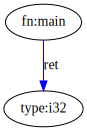

In [41]:
main = Fn('main') ; main['ret'] = i32
print(main) ; main.plot()

Задаем набор параметров функции:


<int:argc> @140570597141640

<array:argv> @140570597141752
	0 = <ptr:> @140570597142144
		0 = <type:char> @140570597142032

<fn:main> @140570597138728
	ret = <type:i32> @140570597113640
	args = <vector:> @140570597142256
		0 = <int:argc> @140570597141640
		1 = <array:argv> @140570597141752
			0 = <ptr:> @140570597142144
				0 = <type:char> @140570597142032


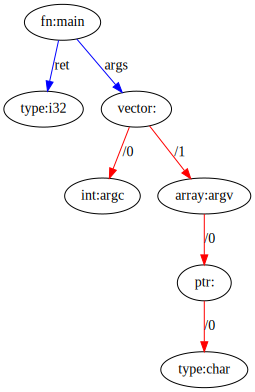

In [42]:
argc = Int('argc') ; print(argc)
argv = Array('argv') // Ptr(Type('char')) ; print(argv)
main['args'] = Vector('') // argc // argv
print(main) ; main.plot()

Вызов внешней функции:

In [43]:
class Include(Meta): pass
stdlib = Include('stdlib.h') ; print(stdlib)


<include:stdlib.h> @140570597141248


In [44]:
printf = Fn('printf') ; stdlib >> printf
printf['ret'] = i32
format = Ptr(Char('format'))
printf['args'] = Vector('') // format // VarArgs()
print(stdlib)


<include:stdlib.h> @140570597141248
	printf = <fn:printf> @140570596649280
		ret = <type:i32> @140570597113640
		args = <vector:> @140570596649392
			0 = <ptr:> @140570596649560
				0 = <char:format> @140570596649224
			1 = <varargs:...> @140570596649728


Добавляем вызов `printf()`:

In [45]:
class Call(Meta):
    def __init__(self,F):
        Meta.__init__(self,F.val) ; self // F

main // Call(printf)


<fn:main> @140570597138728
	ret = <type:i32> @140570597113640
	args = <vector:> @140570597142256
		0 = <int:argc> @140570597141640
		1 = <array:argv> @140570597141752
			0 = <ptr:> @140570597142144
				0 = <type:char> @140570597142032
	0 = <call:printf> @140570596648944
		0 = <fn:printf> @140570596649280
			ret = <type:i32> @140570597113640 _/
			args = <vector:> @140570596649392
				0 = <ptr:> @140570596649560
					0 = <char:format> @140570596649224
				1 = <varargs:...> @140570596649728


<fn:main> @140570597138728
	ret = <type:i32> @140570597113640
	args = <vector:> @140570597142256
		0 = <int:argc> @140570597141640
		1 = <array:argv> @140570597141752
			0 = <ptr:> @140570597142144
				0 = <type:char> @140570597142032
	0 = <call:printf> @140570596648944
		0 = <fn:printf> @140570596649280
			ret = <type:i32> @140570597113640 _/
			args = <vector:> @140570596649392
				0 = <ptr:> @140570596649560
					0 = <char:format> @140570596649224
				1 = <varargs:...> @140570596649728
	1 = <return:0> @140570597339488
		0 = <int:0> @140570597341168


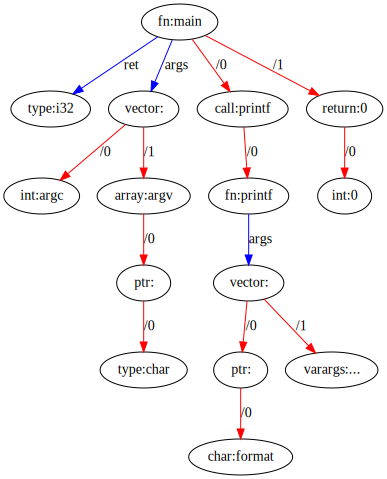

In [46]:
class Return(Meta):
    def __init__(self,Arg):
        Meta.__init__(self,Arg.val) ; self // Arg

main // Return(Int(0))
print(main) ; main.plot()

## Библиотека meteo.kit

In [47]:
! mkdir -p meteo
! touch meteo/__init__.py meteo/kit.py
! find meteo -type f -regex .+.py -exec ls -la {} +

-rw-r--r-- 1 ponyatov ponyatov    0 апр  9 17:39 meteo/__init__.py
-rw-r--r-- 1 ponyatov ponyatov 1938 мар 28 15:33 meteo/.ipynb_checkpoints/kit-checkpoint.py
-rw-r--r-- 1 ponyatov ponyatov 3750 апр  9 17:39 meteo/kit.py


Для использования в пользовательских Jupyter-блокнотах реализация метода вычислений на графах вынесена во внешний Python-модуль. Для использования в вашем блоконоте ее нужно импортировать.

In [48]:
print(Object)  # определение класса Object из блокнота

<class '__main__.Object'>


In [49]:
# from meteo.kit import *  # импорт модуля
print(Object)  # после подгрузки модуля используются библиотечные классы

<class '__main__.Object'>


## Низкоуровневый (кросс-)компилятор / LLVM /

* обработка больших объемов данных, для которой недостаточно скорости Python
* создание самостоятельных программ, не требующих для работы интерпретатора

https://habr.com/ru/post/47878/

В состав `meteo.kit` в качестве примера включен функционал очень ограниченного низкоуровневого компилятора, который использует библиотеку LLVM в качестве backendа. Он генерирует платформенно-независимый код в формате LLVM IR, который затем может быть скомпилирован в машинный код для любой из десятка+ поддерживаемых платформ:
* `x86_64`, `i386`, win32/linux
* `arm9/11`, Raspberry Pi, мобильные телефоны
* `arm-none-eabi`, любые микроконтроллеры архитектуры Cortex-M (STM32, Миландр ВМ1986,..)
* `mipsel32`, массово доступные дешевые SOHO-роутеры на SoC RT5350F
* `avr8` поделки на Arduino для автоматизации

In [50]:
class LLVM(Object): pass

## Метациркулярная реализация

**Метациркулярный интерпретатор** -- интерпретатор языка программирования, написанный на нём самом. Исходный текст реализации языка понятен программисту на этом же языке, и легко может быть изменен, что позволяет 
* делать отладку произвольной сложности вставляя свой отладочный код в интерпретатор, и 
* эксперименировать с языком (менять поведение, добавлять новые возможности).

Так как для метаинтерпретатора используется готовая среда выполнения, не требуется писать полную реализацию языка с нуля, особенно его рантайм. Кроме того, обычно в виде МИ реализуют очень ограниченную версию языка, только те элементы, которые нужны в текущий момент, что очень упрощает код и его понимание. *Метациркулярная реализация* языка скорее относится к написанию компиляторов (на том же языке), и имеет название *bootstrapping*.

В `meteo.kit` *метациркулярное описание системы* включено максимально ограниченно, и только в целях самодокументирования. Это было сделано, чтобы избежать взрывного роста сложности, и превращения **метода метапрограммирования на Python** в самостоятельную систему программирования (графовый язык `metaL`). 

Если вы по собстенной инициативе продолжите расширять систему в этом направлении, добавляя методы генерации высокоуровневого кода (RPython, C++, Rust, Java,..), или компиляции ([LLVM](https://www.ozon.ru/context/detail/id/34342352/), [WASM](https://tproger.ru/translations/introduction-to-webassembly/), байткод), в итоге вы окажетесь один на один с эзотерической системой программирования, которую вам не позволят использовать ни в одном проекте -- никто кроме вас не сможет в дальнейшем заниматься поддержкой, а все косяки и шишки будут вашими. С другой стороны, для прототипирования такой вариант наоборот может быть выигрышным, при условии что прототип используется для уточнения идей и архитектуры, и не идет в production.

### типы узлов объектного графа

#### базовый класс узла

In [51]:
class Class(Meta): pass
cObject = Class('Object')

#### примитивы

In [52]:
cPrimitive = Class('Primitive') ; cObject // cPrimitive
cPrimitive // Class('Symbol') // Class('String')
cPrimitive // ( Class('Number') // ( Class('Integer') // Class('Hex') // Class('Bin') ) ) ;

#### контейнеры данных

In [53]:
cContainer = Class('Container') ; cObject // cContainer
cContainer // Class('Vector') // Class('Dict') // Class('Stack') // Class('Queue') ;

#### активные (исполняемые) данные

In [54]:
cObject // ( ( Class('Active') // Class('Command') // Class('VM') ) ) ;

#### метапрограммирование (программные объекты)

In [55]:
cMeta = Class('Meta') ; cObject // cMeta
cMeta // ( Class('Syntax') // Class('Lexer') // Class('Parser') )
cMeta // ( Class('Module') // Class('Lib') // Class('Exe') )
cMeta // Class('Class') // ( Class('Fn') // Class('Method') ) ;

#### ввод/вывод

In [56]:
cIO = Class('IO') ; cObject // cIO
cIO // Class('Dir') // Class('File')
cNet = Class('Net') ; cIO // cNet
cNet // Class('Socket') // Class('IP') // Class('Port') // Class('Web') ;

#### результирующее дерево классов


<class:Object> @140570596657528
	0 = <class:Primitive> @140570596717960
		0 = <class:Symbol> @140570596718072
		1 = <class:String> @140570596718184
		2 = <class:Number> @140570596717904
			0 = <class:Integer> @140570596718408
				0 = <class:Hex> @140570596718520
				1 = <class:Bin> @140570596718632
	1 = <class:Container> @140570596719304
		0 = <class:Vector> @140570596719416
		1 = <class:Dict> @140570596719528
		2 = <class:Stack> @140570596719640
		3 = <class:Queue> @140570596719752
	2 = <class:Active> @140570596720368
		0 = <class:Command> @140570596720480
		1 = <class:VM> @140570596720592
	3 = <class:Meta> @140570597188720
		0 = <class:Syntax> @140570597191408
			0 = <class:Lexer> @140570597155056
			1 = <class:Parser> @140570597158584
		1 = <class:Module> @140570597191184
			0 = <class:Lib> @140570597155616
			1 = <class:Exe> @140570597608976
		2 = <class:Class> @140570597157296
		3 = <class:Fn> @140570597606456
			0 = <class:Method> @140570597451368
	4 = <class:IO> @14057059671829

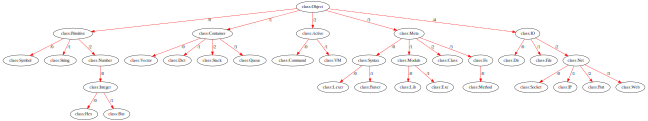

In [57]:
print(cObject) ; cObject.plot()

## Унификация и pattern matching

Для работы с графами удобно использовать методику **сопоставления с шаблонами**, использование которой позволяет *применять к графам наборы правил преобразования* (декларативное программирование). Для реализации **структурной унификации** используется методика, описанная в 
* [YieldProlog](http://yieldprolog.sourceforge.net/)

Второй необходимый компонент -- **backtracking**, поиск решений в глубину с возвратами. Используется рекурсивный обход дерева возможных вариантов, до тех пор пока не находится одно из решений, или становится ясно что текущая ветка поиска решений не имеет.
* https://www.geeksforgeeks.org/backtracking-algorithms/

### Введение в использование генераторов

Использование ключевого слова `yield` в любом месте обычной функции превращает её в особый вид: при вызове функции вместо ее исполнения возвращется объект типа `generator`, который используется для управления.
* https://webdevblog.ru/vvedenie-v-generatory-python/

Функция, обернутая в генератор, может прерываться в любом месте в т.ч. с возвратом некоторого значения, а затем возобновляться с того же места:

In [58]:
def iterCounter():
    n = 0
    yield 'begin loop'
    while n < 3:
        yield n
        n += 1
    yield 'end loop'
    return 'done' # возвращается как параметр исключения StopIteration

iterator = iterCounter() ; print(iterator)
for i in iterator: print(i)
print(iterator)

<generator object iterCounter at 0x7fd9248219a8>
begin loop
0
1
2
end loop
<generator object iterCounter at 0x7fd9248219a8>


Также возможно пошаговое выполнение генератора через встроенную функцию `next()`. При вызове `next()` для завершенного итератора возникает исключение `StopIteration`.

In [59]:
iterator = iterCounter()
try:
    print(next(iterator)) ; print(next(iterator)) ; print(next(iterator))
    print(next(iterator)) ; print(next(iterator)) ; print(next(iterator))
except StopIteration as e:
    print('StopIteration:%s' % e)

begin loop
0
1
2
end loop
StopIteration:done


Свойство генераторов прерывать исполнение в середине функции, и продолжать выполнение при следующем вызове позволяет реализовать механизм backtracking из языка Пролог (обход дерева состояний в глубину).
* http://yieldprolog.sourceforge.net/tutorial1.html

In [60]:
def ValuesGenerator():
    yield "Chelsea"
    yield "Hillary"
    yield "Bill"
print(ValuesGenerator)
print(ValuesGenerator())

<function ValuesGenerator at 0x7fd924886a60>
<generator object ValuesGenerator at 0x7fd924821930>


In [61]:
def main():
    print("Names using a return value:")
    for p in ValuesGenerator(): print(p)
main()

Names using a return value:
Chelsea
Hillary
Bill


Цикл `for` выполняет обход вариантов (несколько имен) вызывая генератор:

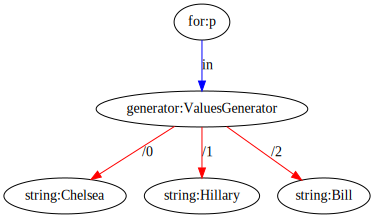

In [62]:
class For(Meta): pass
class Generator(Meta): pass
forloop = For('p')
ValuesGenerator = Generator('ValuesGenerator')
ValuesGenerator // String('Chelsea') // String('Hillary') // String('Bill')
forloop['in'] = ValuesGenerator
forloop.plot()

Для реализации аналогичной схемы в модели EDS можно использовать возможность Python работать с любым объектом как с генератором, если у него определен метод `__next__()`.

In [63]:
def __iter__(self):
    return self.__next__()
def __next__(self):
    for j in self.nest: yield j

setattr(Object, '__iter__', __iter__)
setattr(Object, '__next__', __next__)

ValuesGenerator = Generator('ValuesGenerator')
ValuesGenerator // String('Chelsea') // String('Hillary') // String('Bill')
for p in ValuesGenerator:
    print(p)


<string:Chelsea> @140570596763128

<string:Hillary> @140570597262728

<string:Bill> @140570596763408
